# Weekly S&P 500 Closing-Price Prediction with LightGBM Regressor

This notebook demonstrates a full ML workflow to **forecast next week’s S&P 500 close** on weekly bars.

1. **Data Acquisition:** Pull daily data in one request, flatten columns, then resample to weekly bars.  
2. **Feature Engineering:** Compute RSI, EMA crossover, ATR, VWAP deviation, volume spikes, yield spread, and 20-week trend strength.  
3. **Model Training:** Split into hold-out (last 52 weeks or 20%), train a `LGBMRegressor`, and evaluate with MSE/MAE/R².  
4. **Diagnostics:** Plot actual vs. predicted prices and display feature importances.


In [1]:
import yfinance as yf
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

In [2]:
def fetch_history(ticker, period="max", interval="1d", max_retries=5):
    """
    Fetch historical OHLCV for `ticker` via yf.Ticker.history(),
    with exponential backoff on rate limits.
    """
    for attempt in range(max_retries):
        try:
            df = yf.Ticker(ticker).history(period=period, interval=interval)
            # ensure we have the needed columns
            return df[['Open','High','Low','Close','Volume']]
        except yutils.YFRateLimitError:
            wait = 2 ** attempt
            print(f"Rate limit hit, retrying in {wait}s…")
            time.sleep(wait)
    raise RuntimeError(f"Failed to fetch {ticker} after {max_retries} retries")

# 1) Download daily S&P data
daily = fetch_history("^GSPC")

# 2) Resample to weekly bars (Friday close)
weekly = (
    daily.resample('W-FRI').agg({
        'Open':   'first',
        'High':   'max',
        'Low':    'min',
        'Close':  'last',
        'Volume': 'sum'
    })
    .iloc[:-1]  # drop the final partial week
    .copy()
)

# 3) Create regression target: next week's Close
weekly['Target_Price'] = weekly['Close'].shift(-1)
weekly.dropna(subset=['Target_Price'], inplace=True)

## Feature Engineering

In this cell we compute all of our weekly technical and macro features:

- **RSI (14-week):** measures recent momentum  
- **EMA crossover (50 vs 200-week):** trend-following signal  
- **ATR (14-week):** average true range for volatility  
- **VWAP deviation:** price vs volume-weighted average price  
- **Volume spike (4-week avg):** unusually high trading volume  
- **Yield spread (10yr – 5yr):** interest-rate differential  
- **Trend strength (20-week up-count):** how many of the last 20 weeks were up  

In [3]:
# RSI (14-week)
delta    = weekly['Close'].diff()
gain     = delta.clip(lower=0)
loss     = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
weekly['RSI_14'] = 100 - (100 / (1 + avg_gain/avg_loss))

# EMA crossover (50 vs 200 weeks)
weekly['EMA_50']   = weekly['Close'].ewm(span=50,  adjust=False).mean()
weekly['EMA_200']  = weekly['Close'].ewm(span=200, adjust=False).mean()
weekly['MA_Cross'] = (weekly['EMA_50'] > weekly['EMA_200']).astype(int)

# ATR (14 weeks)
hl = weekly['High'] - weekly['Low']
hp = (weekly['High'] - weekly['Close'].shift()).abs()
lp = (weekly['Low']  - weekly['Close'].shift()).abs()
tr = pd.concat([hl, hp, lp], axis=1).max(axis=1)
weekly['ATR_14'] = tr.rolling(14).mean()

# VWAP deviation
vwap = (weekly['Close'] * weekly['Volume']).cumsum() / weekly['Volume'].cumsum()
weekly['VWAP_dev'] = weekly['Close'] / vwap

# Volume spike (4-week average)
weekly['Vol_Avg_4'] = weekly['Volume'].rolling(4).mean()
weekly['Vol_Spike']  = weekly['Volume'] / weekly['Vol_Avg_4']

# Yield spread (10yr – 5yr)
tnx = yf.Ticker("^TNX").history(period="max")["Close"]
fvx = yf.Ticker("^FVX").history(period="max")["Close"]
tnx = tnx.reindex(weekly.index, method="ffill")
fvx = fvx.reindex(weekly.index, method="ffill")
weekly['Yield_Spread'] = (tnx - fvx) / 10

# Trend strength (20-week up-count)
weekly['Trend_20'] = weekly['Close'].shift(1) < weekly['Close']
weekly['Trend_20'] = weekly['Trend_20'].astype(int).rolling(20).sum()

In [53]:
# Drop any rows missing engineered features
feature_cols = [
    'RSI_14','MA_Cross','ATR_14','VWAP_dev',
    'Vol_Spike','Yield_Spread','Trend_20'
]
weekly.dropna(subset=feature_cols + ['Target_Price'], inplace=True)

# Hold-out: last 52 weeks or 20% of data, whichever smaller
n = len(weekly)
test_size = min(int(n * 0.2), 52)
train, test = weekly.iloc[:-test_size], weekly.iloc[-test_size:]

X_train = train[feature_cols]
y_train = train['Target_Price']
X_test  = test [feature_cols]
y_test  = test ['Target_Price']

# Fit LightGBM regressor
model = LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.3,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error( y_test, y_pred))
print("R²:",  r2_score(          y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1291
[LightGBM] [Info] Number of data points in the train set: 3251, number of used features: 7
[LightGBM] [Info] Start training from score 949.992212
MSE: 1118113.9516107114
MAE: 938.0226628934678
R²: -12.919185976005076


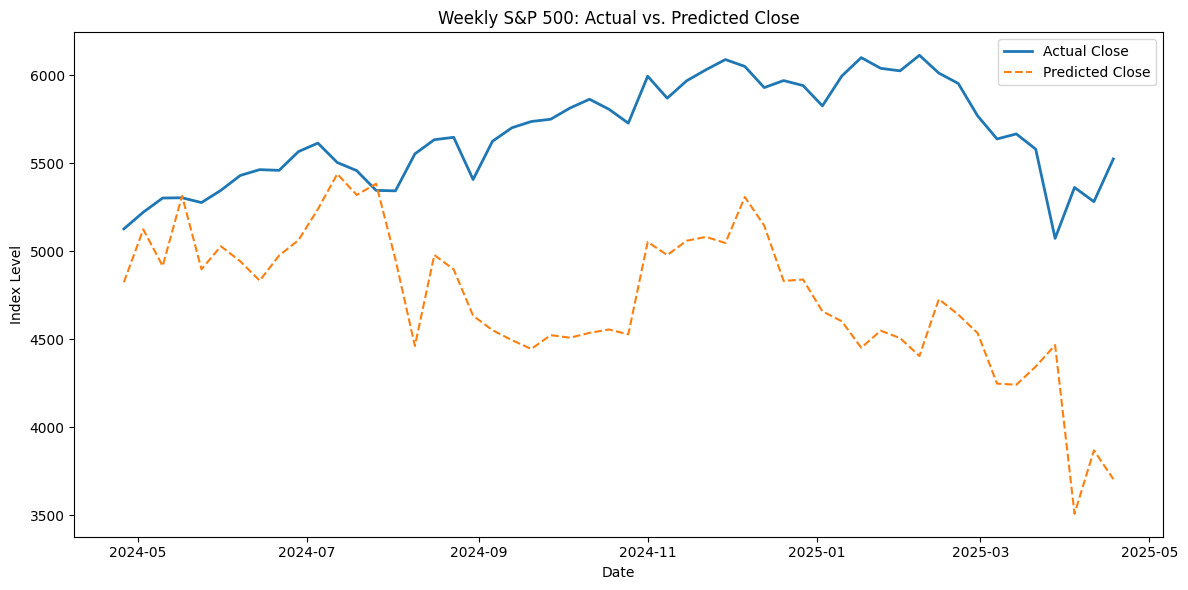

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test,  label='Actual Close', linewidth=2)
plt.plot(test.index, y_pred,  label='Predicted Close', linestyle='--')
plt.title("Weekly S&P 500: Actual vs. Predicted Close")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.tight_layout()
plt.show()

Feature importances (highest→lowest):
Vol_Spike       33060
RSI_14          30308
VWAP_dev        27540
Yield_Spread    27396
ATR_14          24819
Trend_20         6586
MA_Cross          291
dtype: int32


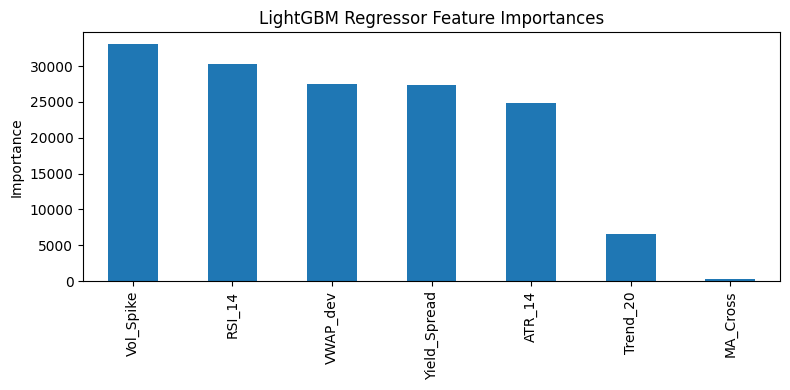

In [43]:
importances = pd.Series(model.feature_importances_, index=feature_cols)
importances = importances.sort_values(ascending=False)

print("Feature importances (highest→lowest):")
print(importances)

# Bar chart
importances.plot(kind='bar', figsize=(8,4))
plt.title("LightGBM Regressor Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()